Install Required Libraries

In [1]:
pip install tensorflow opencv-python matplotlib seaborn scikit-lear

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement scikit-lear (from versions: none)
ERROR: No matching distribution found for scikit-lear

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Import Libraries

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


Set Local Dataset Paths

In [3]:
BASE_PATH = r"D:\Diabetic Rectinopathy Detection\Datasets"
IMAGE_PATH = os.path.join(BASE_PATH, "train_images")
CSV_PATH = os.path.join(BASE_PATH, "train.csv")



Load CSV File

In [4]:
df = pd.read_csv(CSV_PATH)
print(df.head())


        id_code  diagnosis
0  1ae8c165fd53          2
1  1b329a127307          1
2  1b32e1d775ea          4
3  1b3647865779          0
4  1b398c0494d1          0


Verify Class Distribution

In [5]:
print(df['diagnosis'].value_counts())


diagnosis
0    1434
2     808
1     300
4     234
3     154
Name: count, dtype: int64


Verify the Image File Exists

In [6]:
sample_id = df.iloc[0]['id_code']
sample_image_path = os.path.join(IMAGE_PATH, sample_id + ".png")

print("Image path:", sample_image_path)
print("Exists:", os.path.exists(sample_image_path))


Image path: D:\Diabetic Rectinopathy Detection\Datasets\train_images\1ae8c165fd53.png
Exists: True


Display a Fundas of Image

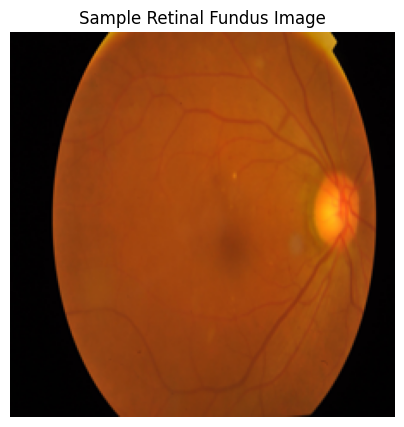

In [7]:
img = cv2.imread(sample_image_path)

if img is None:
    raise ValueError("Image not loaded. Check path.")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title("Sample Retinal Fundus Image")
plt.axis('off')
plt.show()


Confirm Number of Classes

In [8]:
num_classes = df['diagnosis'].nunique()
print("Number of Classes:", num_classes)


Number of Classes: 5


Convert Labels to String (IMPORTANT FOR GENERATORS)

In [9]:
df['diagnosis'] = df['diagnosis'].astype(str)
df.dtypes


id_code      object
diagnosis    object
dtype: object

Visualize Class Distribution

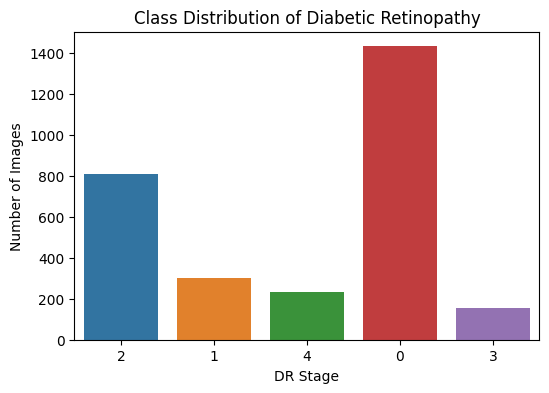

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='diagnosis', data=df)
plt.title("Class Distribution of Diabetic Retinopathy")
plt.xlabel("DR Stage")
plt.ylabel("Number of Images")
plt.show()


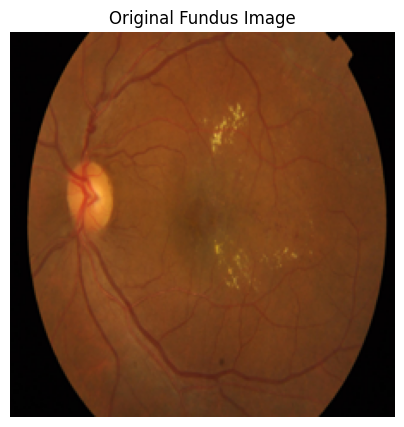

In [11]:
sample_id = df.iloc[10]['id_code']
img_path = os.path.join(IMAGE_PATH, sample_id + ".png")

img = cv2.imread(img_path)

if img is None:
    raise ValueError("Image not found. Check dataset path.")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title("Original Fundus Image")
plt.axis('off')
plt.show()


Convert to Grayscale

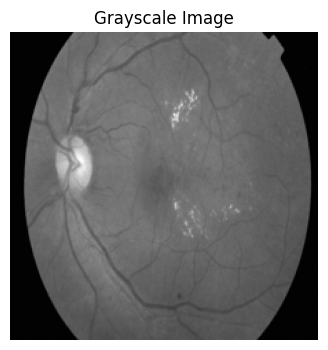

In [12]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(4,4))
plt.imshow(gray, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()


Apply Gaussian Blur (Noise Reduction)

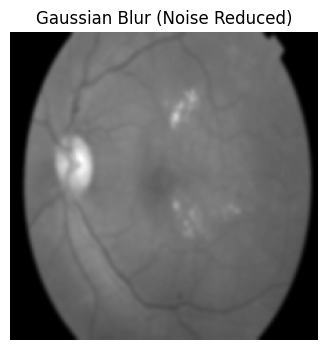

In [13]:
gaussian = cv2.GaussianBlur(gray, (7,7), 0)

plt.figure(figsize=(4,4))
plt.imshow(gaussian, cmap='gray')
plt.title("Gaussian Blur (Noise Reduced)")
plt.axis('off')
plt.show()


Apply CLAHE (Contrast Enhancement)

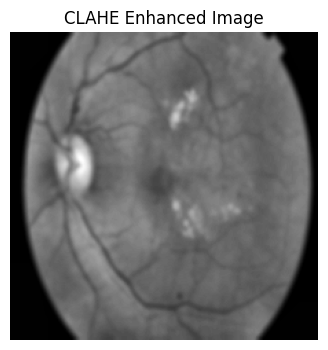

In [14]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_img = clahe.apply(gaussian)

plt.figure(figsize=(4,4))
plt.imshow(clahe_img, cmap='gray')
plt.title("CLAHE Enhanced Image")
plt.axis('off')
plt.show()


COMBINED VISUALIZATION

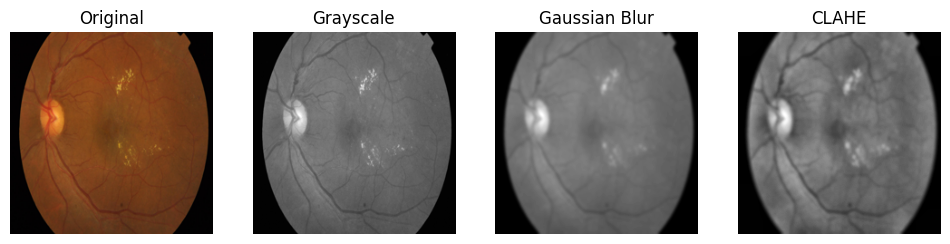

In [15]:
titles = ["Original", "Grayscale", "Gaussian Blur", "CLAHE"]
images = [img, gray, gaussian, clahe_img]

plt.figure(figsize=(12,4))
for i in range(4):
    plt.subplot(1,4,i+1)

    if i == 0:
        plt.imshow(images[i])          # RGB image
    else:
        plt.imshow(images[i], cmap='gray')

    plt.title(titles[i])
    plt.axis('off')

plt.show()


Apply Adaptive Thresholding

In [16]:
thresh = cv2.adaptiveThreshold(
    clahe_img,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    11,
    2
)

Display Black & White Image

(-0.5, 223.5, 223.5, -0.5)

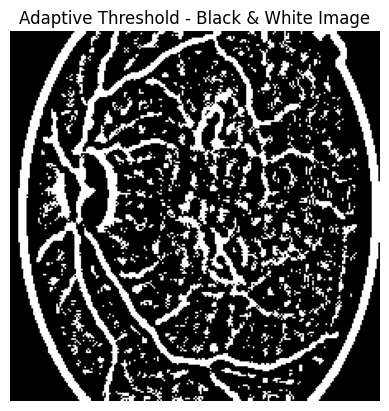

In [18]:
plt.imshow(thresh, cmap='gray')
plt.title("Adaptive Threshold - Black & White Image")
plt.axis('off')

COMPARISON VIEW

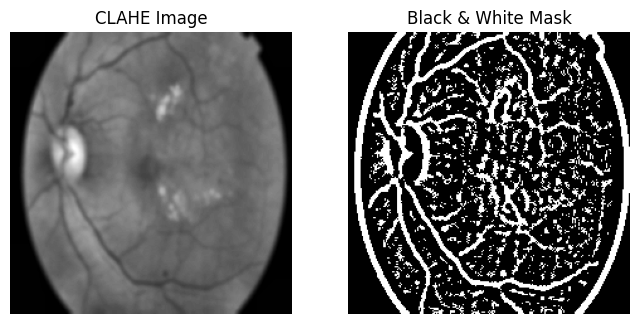

In [19]:
titles = ["CLAHE Image", "Black & White Mask"]
images = [clahe_img, thresh]

plt.figure(figsize=(8,4))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.show()


Define Morphological Kernel

In [20]:
kernel = np.ones((5,5), np.uint8)

Apply Morphological Closing

(-0.5, 223.5, 223.5, -0.5)

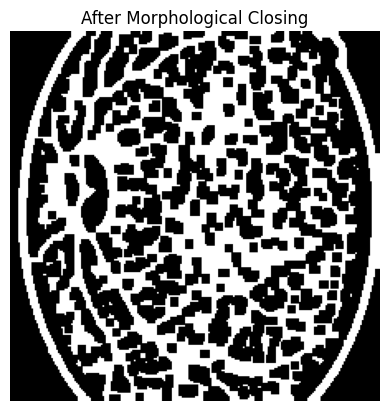

In [21]:
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

plt.imshow(closing, cmap='gray')
plt.title("After Morphological Closing")
plt.axis('off')

Apply Morphological Opening

(-0.5, 223.5, 223.5, -0.5)

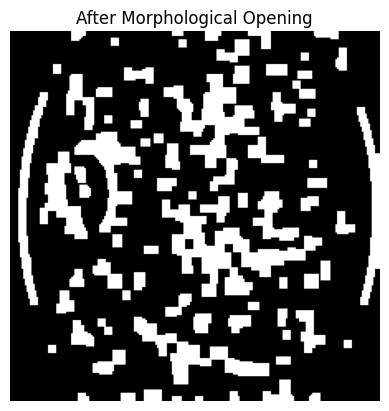

In [22]:
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

plt.imshow(opening, cmap='gray')
plt.title("After Morphological Opening")
plt.axis('off')

COMPARISON VIEW

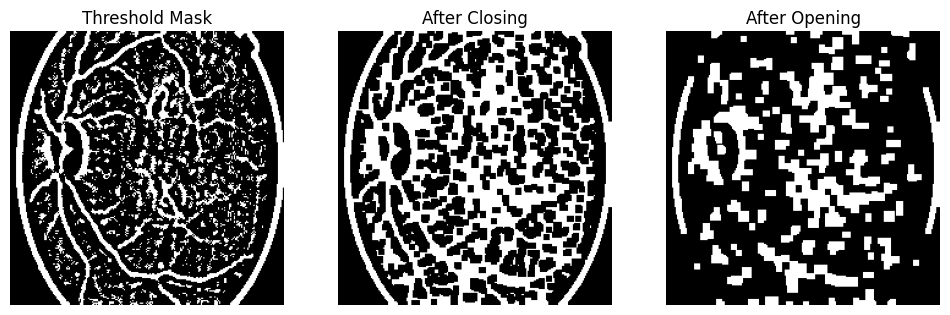

In [23]:
titles = ["Threshold Mask", "After Closing", "After Opening"]
images = [thresh, closing, opening]

plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.show()


Smooth the Image (Reduce Noise)




In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

blur = cv2.GaussianBlur(gray, (7, 7), 0)

Binary Segmentation (Otsu Threshold)

In [18]:
_, thresh = cv2.threshold(
    blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

Morphological Closing (Fix Gaps)

In [19]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)


Remove Small Noise (Keep Only Retina)

In [20]:
contours, _ = cv2.findContours(
    closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

retina_contour = max(contours, key=cv2.contourArea)

Apply Convex Hull (CRITICAL FIX)

In [21]:
hull = cv2.convexHull(retina_contour)

Create Filled Retina Mask

(-0.5, 223.5, 223.5, -0.5)

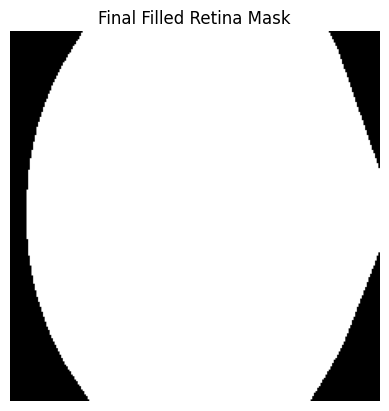

In [22]:
retina_mask = np.zeros_like(gray)
cv2.drawContours(retina_mask, [hull], -1, 255, thickness=-1)

plt.imshow(retina_mask, cmap='gray')
plt.title("Final Filled Retina Mask")
plt.axis('off')


Draw Full Green Boundary on Original Image

(-0.5, 223.5, 223.5, -0.5)

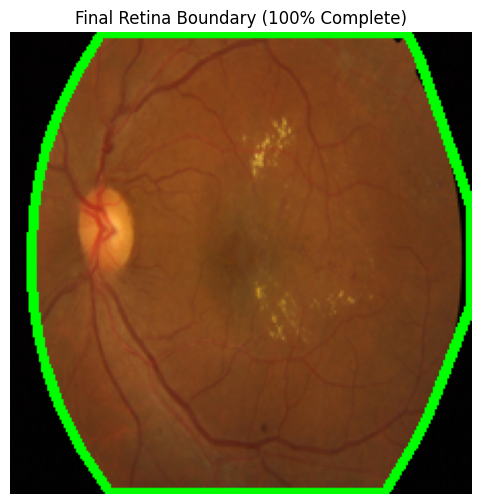

In [23]:
overlay = img.copy()
cv2.drawContours(overlay, [hull], -1, (0, 255, 0), 4)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title("Final Retina Boundary (100% Complete)")
plt.axis('off')

APPLY RETINA MASK (ROI ISOLATION)

(-0.5, 223.5, 223.5, -0.5)

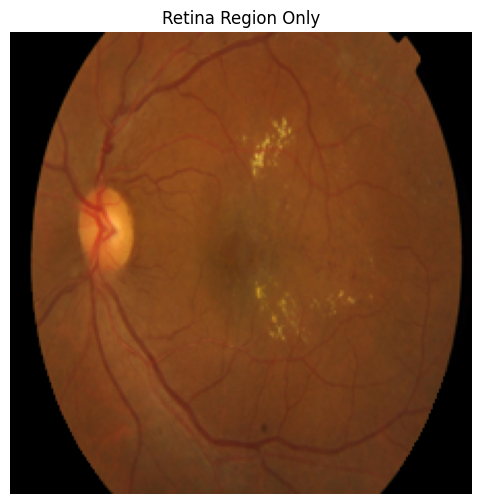

In [24]:
retina_only = cv2.bitwise_and(img, img, mask=retina_mask)

plt.figure(figsize=(6,6))
plt.imshow(retina_only)
plt.title("Retina Region Only")
plt.axis('off')


Exudate Detection(Bright Lesions)

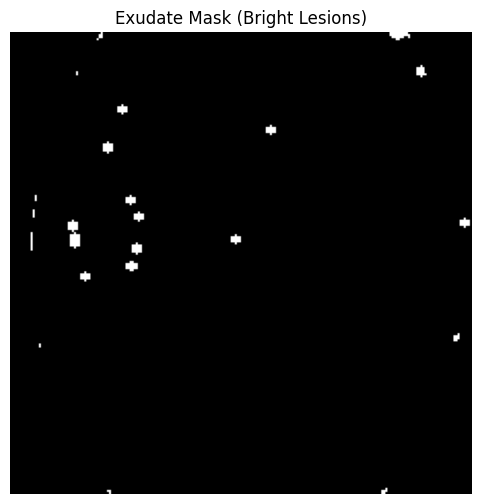

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

green_channel = img_rgb[:, :, 1]

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
green_clahe = clahe.apply(green_channel)

exudate_thresh = cv2.adaptiveThreshold(
    green_clahe,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    11,
    2
)


exudate_thresh = cv2.bitwise_not(exudate_thresh)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
exudate_mask = cv2.morphologyEx(
    exudate_thresh,
    cv2.MORPH_OPEN,
    kernel
)

exudate_mask = cv2.bitwise_and(
    exudate_mask,
    exudate_mask,
    mask=retina_mask
)

plt.figure(figsize=(6,6))
plt.imshow(exudate_mask, cmap='gray')
plt.title("Exudate Mask (Bright Lesions)")
plt.axis('off')
plt.show()



Hemorrhage Detection(Dark Lesions)

(-0.5, 223.5, 223.5, -0.5)

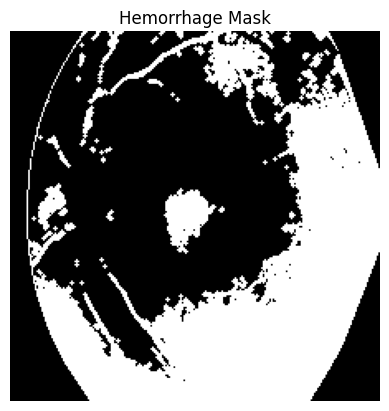

In [25]:
gray = cv2.cvtColor(retina_only, cv2.COLOR_BGR2GRAY)

# Hemorrhages are DARK → use inverse binary
_, hemorrhage_mask = cv2.threshold(
    gray, 60, 255, cv2.THRESH_BINARY_INV
)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
hemorrhage_mask = cv2.morphologyEx(hemorrhage_mask, cv2.MORPH_OPEN, kernel)

hemorrhage_mask = cv2.bitwise_and(
    hemorrhage_mask, hemorrhage_mask, mask=retina_mask
)

plt.imshow(hemorrhage_mask, cmap='gray')
plt.title("Hemorrhage Mask")
plt.axis('off')


Combine All Lesions

(-0.5, 223.5, 223.5, -0.5)

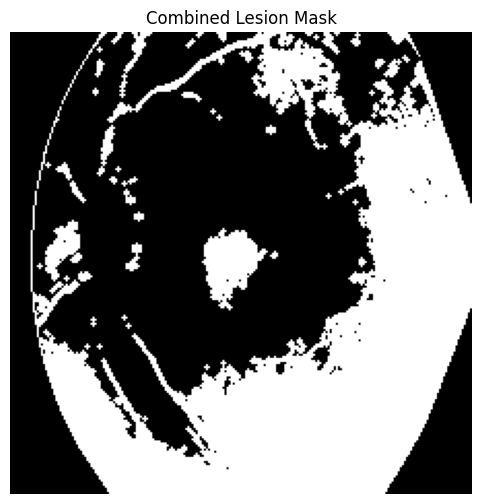

In [27]:
lesion_mask = cv2.bitwise_or(exudate_mask, hemorrhage_mask)

plt.figure(figsize=(6,6))
plt.imshow(lesion_mask, cmap='gray')
plt.title("Combined Lesion Mask")
plt.axis('off')

Overlay Lesions on Original Image

(-0.5, 223.5, 223.5, -0.5)

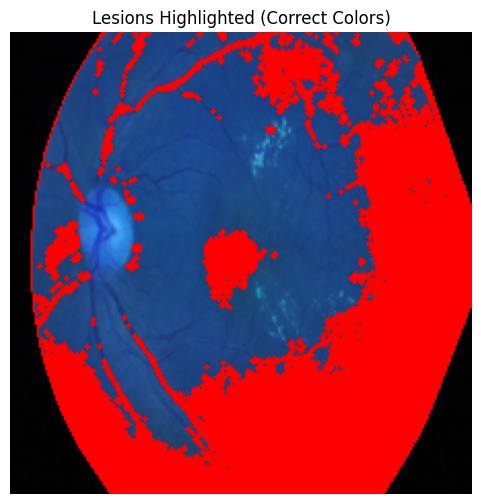

In [28]:
overlay = img.copy()

# OpenCV BGR → RED = (0,0,255)
overlay[lesion_mask > 0] = (0, 0, 255)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Lesions Highlighted (Correct Colors)")
plt.axis('off')

In [29]:
pip install tensorflow opencv-python albumentations


Defaulting to user installation because normal site-packages is not writeable
  Using cached albumentations-2.0.8-py3-none-any.whl (369 kB)
  Using cached opencv_python_headless-4.13.0.90-cp37-abi3-win_amd64.whl (40.1 MB)
  Using cached albucore-0.0.24-py3-none-any.whl (15 kB)
  Using cached pydantic-2.12.5-py3-none-any.whl (463 kB)
  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-win_amd64.whl (38.9 MB)
  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-win_amd64.whl (39.4 MB)
  Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Akshay Khanna T K\\AppData\\Roaming\\Python\\Python310\\site-packages\\cv2\\cv2.pyd'
Check the permissions.


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
DATASET_PATH = r"D:\Diabetic Rectinopathy Detection\Datasets\train_images"
CSV_PATH = r"D:\Diabetic Rectinopathy Detection\Datasets\train.csv"

IMG_SIZE = 299   # InceptionV3
BATCH_SIZE = 16  # good for local GPU / CPU
NUM_CLASSES = 5


In [35]:
IMG_SIZE = 299


Load Labels(APTOS CSV)

In [36]:
import pandas as pd

df = pd.read_csv(CSV_PATH)
df['id_code'] = df['id_code'].apply(lambda x: x + ".png")

df.head()


,id_code,diagnosis
0,1ae8c165fd53.png,2
1,1b329a127307.png,1
2,1b32e1d775ea.png,4
3,1b3647865779.png,0
4,1b398c0494d1.png,0


Image Preprocessing Function

In [37]:
import cv2
import numpy as np
import tensorflow as tf

def preprocess_image(DATASET_PATH):
    img = cv2.imread(DATASET_PATH)

    if img is None:
        raise ValueError(f"Image not found: {DATASET_PATH}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img


Create Data Generator

In [38]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['diagnosis'],
    random_state=42
)

def data_generator(dataframe, batch_size=BATCH_SIZE):
    while True:
        dataframe = dataframe.sample(frac=1).reset_index(drop=True)

        for i in range(0, len(dataframe), batch_size):
            batch_df = dataframe.iloc[i:i+batch_size]

            images = []
            labels = []

            for _, row in batch_df.iterrows():
                img_path = os.path.join(DATASET_PATH, row['id_code'])
                img = preprocess_image(img_path)

                images.append(img)
                labels.append(row['diagnosis'])

            images = np.array(images)
            labels = tf.keras.utils.to_categorical(labels, NUM_CLASSES)

            yield images, labels


In [ ]:

# ===============================
# DATA AUGMENTATION + CLASS WEIGHTS
# ===============================
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# --------------------------------
# 1️⃣ CALCULATE CLASS WEIGHTS (for imbalanced dataset)
# --------------------------------
class_weights_dict = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['diagnosis'].astype(int)),
    y=train_df['diagnosis'].astype(int)
)

class_weights = dict(enumerate(class_weights_dict))

print("📊 Class Weights (AUTOMATICALLY CALCULATED FROM YOUR DATA):")
class_names_short = ["No DR", "Mild", "Moderate", "Severe", "Proliferative"]
for class_id, weight in class_weights.items():
    print(f"  Class {class_id} ({class_names_short[class_id]}): {weight:.4f}")

print("\n💡 These weights are calculated based on your actual class distribution!")
print("💡 Rarer classes get higher weights to prevent the model from ignoring them.")

# --------------------------------
# 2️⃣ DATA AUGMENTATION SETUP
# --------------------------------
augment = ImageDataGenerator(
    rotation_range=20,              # Random rotation ±20°
    width_shift_range=0.2,          # Random horizontal shift 20%
    height_shift_range=0.2,         # Random vertical shift 20%
    shear_range=0.2,                # Shear transformation
    zoom_range=0.2,                 # Random zoom 80-120%
    brightness_range=[0.8, 1.2],    # Brightness adjustment
    horizontal_flip=True,           # Random horizontal flip
    fill_mode='nearest'             # Fill pixels after transformations
)

# --------------------------------
# 3️⃣ UPDATED DATA GENERATOR WITH AUGMENTATION
# --------------------------------
def data_generator_augmented(dataframe, batch_size=BATCH_SIZE, augment=None):
    while True:
        dataframe = dataframe.sample(frac=1).reset_index(drop=True)
        
        for i in range(0, len(dataframe), batch_size):
            batch_df = dataframe.iloc[i:i+batch_size]
            
            images = []
            labels = []
            
            for _, row in batch_df.iterrows():
                img_path = os.path.join(DATASET_PATH, row['id_code'])
                img = preprocess_image(img_path)
                
                # Apply augmentation ONLY to training data
                if augment is not None:
                    img = augment.random_transform(img)
                
                images.append(img)
                labels.append(row['diagnosis'])
            
            images = np.array(images)
            labels = tf.keras.utils.to_categorical(labels, NUM_CLASSES)
            
            yield images, labels

print("\n✅ Data augmentation ready!")
print("✅ Class weights computed for handling imbalance!")


Build InceptionV3 Model

In [39]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0

Model Training

In [ ]:

import os
import math
import numpy as np
import tensorflow as tf

# --------------------------------
# START TRAINING WITH CLASS WEIGHTS
# --------------------------------
history = model.fit(
    data_generator_augmented(train_df, augment=augment),
    validation_data=data_generator_augmented(val_df, augment=None),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=15,
    verbose=1,
    class_weight=class_weights  # ← HANDLES IMBALANCED DATA
)


Steps per epoch: 147
Validation steps: 37
Epoch 1/10


147/147 [==============================] - 141s 908ms/step - loss: 0.8984 - accuracy: 0.6813 - val_loss: 0.6779 - val_accuracy: 0.7543
Epoch 2/10
147/147 [==============================] - 118s 807ms/step - loss: 0.6573 - accuracy: 0.7500 - val_loss: 0.6798 - val_accuracy: 0.7526
Epoch 3/10
147/147 [==============================] - 109s 740ms/step - loss: 0.5814 - accuracy: 0.7760 - val_loss: 0.6207 - val_accuracy: 0.7850
Epoch 4/10
147/147 [==============================] - 108s 737ms/step - loss: 0.5710 - accuracy: 0.7850 - val_loss: 0.6290 - val_accuracy: 0.7730
Epoch 5/10
147/147 [==============================] - 106s 722ms/step - loss: 0.5296 - accuracy: 0.8080 - val_loss: 0.6558 - val_accuracy: 0.7765
Epoch 6/10
147/147 [==============================] - 114s 777ms/step - loss: 0.5148 - accuracy: 0.8063 - val_loss: 0.6087 - val_accuracy: 0.7611
Epoch 7/10
147/147 [==============================] - 106s 724ms/step - loss: 0.

Fine Tuning

In [43]:
import tensorflow as tf

# --------------------------------
# CHECK TOTAL LAYERS
# --------------------------------
print(f"Total base_model layers: {len(base_model.layers)}")

# --------------------------------
# UNFREEZE ALL LAYERS IN BASE MODEL
# --------------------------------
base_model.trainable = True

# --------------------------------
# FREEZE ONLY EARLY LAYERS (keep last ~100 trainable)
# --------------------------------
num_layers = len(base_model.layers)
freeze_until = num_layers - 100  # Keep last 100 layers trainable

for layer in base_model.layers[:freeze_until]:
    layer.trainable = False

print(f"\nFrozing layers 0 to {freeze_until}")
print(f"Trainable layers: {freeze_until} to {num_layers}")

# --------------------------------
# CHECK TRAINABLE LAYERS COUNT
# --------------------------------
trainable_count = sum(1 for layer in base_model.layers if layer.trainable)
frozen_count = sum(1 for layer in base_model.layers if not layer.trainable)

print(f"\nTrainable layers in base_model: {trainable_count}")
print(f"Frozen layers in base_model: {frozen_count}")

# --------------------------------
# RECOMPILE WITH LOW LEARNING RATE
# --------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --------------------------------
# FINE-TUNING WITH CLASS WEIGHTS + AUGMENTATION
# --------------------------------
history_finetune = model.fit(
    data_generator_augmented(train_df, augment=augment),
    validation_data=data_generator_augmented(val_df, augment=None),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=15,
    verbose=1,
    class_weight=class_weights  # ← HANDLES IMBALANCED DATA
)

print("\n✅ Fine-tuning completed with class weights + augmentation!")


Total base_model layers: 311

Frozing layers 0 to 211
Trainable layers: 211 to 311

Trainable layers in base_model: 100
Frozen layers in base_model: 211

Trainable layers after fine-tuning:
  ✅ batch_normalization_62: True
  ✅ batch_normalization_67: True
  ✅ activation_62: True
  ✅ activation_67: True
  ✅ average_pooling2d_6: True
  ✅ conv2d_60: True
  ✅ conv2d_63: True
  ✅ conv2d_68: True
  ✅ conv2d_69: True
  ✅ batch_normalization_60: True
  ✅ batch_normalization_63: True
  ✅ batch_normalization_68: True
  ✅ batch_normalization_69: True
  ✅ activation_60: True
  ✅ activation_63: True
  ✅ activation_68: True
  ✅ activation_69: True
  ✅ mixed7: True
  ✅ conv2d_72: True
  ✅ batch_normalization_72: True
  ✅ activation_72: True
  ✅ conv2d_73: True
  ✅ batch_normalization_73: True
  ✅ activation_73: True
  ✅ conv2d_70: True
  ✅ conv2d_74: True
  ✅ batch_normalization_70: True
  ✅ batch_normalization_74: True
  ✅ activation_70: True
  ✅ activation_74: True
  ✅ conv2d_71: True
  ✅ conv2d_75

KeyboardInterrupt: 

Save Model

In [44]:
MODEL_PATH = r"D:\Diabetic Rectinopathy Detection\Models\dr_inception_model_final.h5"

model.save(MODEL_PATH)

print("Model saved successfully at:", MODEL_PATH)


C:\Users\Akshay Khanna T K\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully at: D:\Diabetic Rectinopathy Detection\Models\dr_inception_model_final.h5


Final training + Evaluation

In [46]:
import tensorflow as tf
import numpy as np
import cv2

# ===============================
# CONFIG
# ===============================
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_CLASSES = 5
EPOCHS = 15

# ===============================
# DATA GENERATOR (FIXED)
# ===============================
def data_generator(df, batch_size=BATCH_SIZE, is_training=True):
    while True:
        df = df.sample(frac=1).reset_index(drop=True)  # shuffle
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]

            images = []
            labels = []

            for _, row in batch_df.iterrows():
                # ✅ CORRECT - use actual column names
                img_path = os.path.join(DATASET_PATH, row['id_code'])
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img / 255.0

                images.append(img)
                # ✅ CORRECT - use 'diagnosis' column
                labels.append(int(row['diagnosis']))

            yield np.array(images), tf.keras.utils.to_categorical(labels, NUM_CLASSES)

# ===============================
# STEPS CALCULATION (IMPORTANT)
# ===============================
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE

# ===============================
# CALLBACKS
# ===============================
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "dr_model_best.h5",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        verbose=1
    )
]

# ===============================
# MODEL TRAINING
# ===============================
history = model.fit(
    data_generator(train_df),
    validation_data=data_generator(val_df, is_training=False),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=callbacks
)

# ===============================
# SAVE FINAL MODEL
# ===============================
model.save("dr_model_final.h5")

print("✅ Training completed and model saved.")


Epoch 1/15
146/146 [==============================] - ETA: 0s - loss: 0.8145 - accuracy: 0.7461
Epoch 1: val_accuracy improved from -inf to 0.72049, saving model to dr_model_best.h5
146/146 [==============================] - 65s 447ms/step - loss: 0.8145 - accuracy: 0.7461 - val_loss: 1.1136 - val_accuracy: 0.7205 - lr: 1.0000e-05
Epoch 2/15
146/146 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.8630
Epoch 2: val_accuracy improved from 0.72049 to 0.76316, saving model to dr_model_best.h5
146/146 [==============================] - 64s 443ms/step - loss: 0.3662 - accuracy: 0.8630 - val_loss: 0.9267 - val_accuracy: 0.7632 - lr: 1.0000e-05
Epoch 3/15
146/146 [==============================] - ETA: 0s - loss: 0.2031 - accuracy: 0.9287
Epoch 3: val_accuracy did not improve from 0.76316
146/146 [==============================] - 64s 439ms/step - loss: 0.2031 - accuracy: 0.9287 - val_loss: 0.9185 - val_accuracy: 0.7579 - lr: 1.0000e-05
Epoch 4/15
146/146 [=============

Model Evaluation(Confusion Matrix, Classification report , Accuracy)

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ===============================
# LOAD BEST MODEL (OPTIONAL)
# ===============================
# model = tf.keras.models.load_model("dr_model_best.h5")

# ===============================
# GET TRUE & PREDICTED LABELS
# ===============================
y_true = []
y_pred = []

val_gen = data_generator(val_df, is_training=False)

for _ in range(validation_steps):
    X_batch, y_batch = next(val_gen)

    preds = model.predict(X_batch, verbose=0)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ===============================
# CLASS NAMES
# ===============================
class_names = [
    "No DR",
    "Mild DR",
    "Moderate DR",
    "Severe DR",
    "Proliferative DR"
]

# ===============================
# CLASSIFICATION REPORT
# ===============================
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===============================
# CONFUSION MATRIX
# ===============================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Diabetic Retinopathy Detection")
plt.show()

# ===============================
# OVERALL ACCURACY
# ===============================
accuracy = np.mean(y_true == y_pred)
print(f"\n✅ Validation Accuracy: {accuracy * 100:.2f}%")


ValueError: in user code:

    File "C:\Users\Akshay Khanna T K\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Akshay Khanna T K\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Akshay Khanna T K\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Akshay Khanna T K\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "C:\Users\Akshay Khanna T K\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Akshay Khanna T K\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(None, 224, 224, 3)


Single image prediction

In [ ]:

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# -------------------------------
# 1️⃣ Class labels
# -------------------------------
class_names = [
    "No DR",
    "Mild DR",
    "Moderate DR",
    "Severe DR",
    "Proliferative DR"
]

# -------------------------------
# 2️⃣ Load trained model
# -------------------------------
model_path = "D:\\Diabetic Rectinopathy Detection\\Models\\dr_model_best.h5"   # CHANGE if needed
model = tf.keras.models.load_model(model_path)

print("✅ Model Loaded Successfully")

# -------------------------------
# 3️⃣ Image preprocessing function
# -------------------------------
IMG_SIZE = 224

def preprocess_single_image(image_path):
    img = cv2.imread(image_path)

    if img is None:
        raise ValueError("❌ Image not found! Check path.")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    return img

# -------------------------------
# 4️⃣ Image path (UPLOAD IMAGE)
# -------------------------------
image_path = "/content/test_fundus.jpg"  # 👈 CHANGE IMAGE PATH

# -------------------------------
# 5️⃣ Preprocess + Predict
# -------------------------------
img = preprocess_single_image(image_path)

prediction = model.predict(img)
predicted_class = np.argmax(prediction)
confidence = np.max(prediction)

# -------------------------------
# 6️⃣ Display Result
# -------------------------------
print("🩺 Predicted DR Stage :", class_names[predicted_class])
print("📊 Confidence :", round(confidence * 100, 2), "%")

# -------------------------------
# 7️⃣ Show Image with Prediction
# -------------------------------
img_show = cv2.imread(image_path)
img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img_show)
plt.title(
    f"Prediction: {class_names[predicted_class]}\n"
    f"Confidence: {confidence*100:.2f}%",
    fontsize=12
)
plt.axis("off")
plt.show()
